In [ ]:
from google.colab import drive, auth
import sys
import numpy as np
import pandas as pd
import tensorflow_hub as hub
import librosa
import matplotlib.pyplot as plt
import csv
from IPython.display import Audio

#sklearn libraries
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#tensorflow for modles
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Conv2D, MaxPooling2D, Flatten, concatenate, Reshape, BatchNormalization
import tensorflow_hub as hub
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import Callback,EarlyStopping
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

#mount drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#declare sampling rate
sampling_rate = 16000#read data
bird_df = pd.read_csv('/content/drive/MyDrive/UCB-MIDS/SEM-2/MACHINE-LEARNING-207/207-Project/notebooks/RG/3_species/train_val.csv')
bird_df.head(1)
bird_df.shape

(940, 9)

In [ ]:
# #check how many files are less than 8 sec
# num_rows_less_than_8_sec = len(bird_df[bird_df['duration_secs_32000'] < 8])
# print(num_rows_less_than_8_sec)
# # Filter rows with duration less than 8 seconds
# bird_df = bird_df[bird_df['duration_secs_32000'] >= 8]

146


In [ ]:
#Gather the training data from the main dataset
bird_train_df = bird_df[bird_df['data'] == 'train']
bird_train_df.shape

(657, 9)

In [ ]:
#count the number of species
species_counts = bird_train_df['primary_label'].value_counts()
print(species_counts)

comsan     244
eaywag1    216
barswa     197
Name: primary_label, dtype: int64


In [ ]:
#lets create a separate validation set
bird_val_df =  bird_df[bird_df['data'] == 'val']
bird_val_df.shape

(283, 9)

In [ ]:
#count the number of species
species_counts_val = bird_val_df['primary_label'].value_counts()
print(species_counts_val)

comsan     105
eaywag1     93
barswa      85
Name: primary_label, dtype: int64


In [ ]:
# Group the dataframe by the "primary_label" column and calculate the total duration for each group
label_durations_train = bird_train_df.groupby('primary_label')['duration_secs_32000'].sum()

# Print the result
print(label_durations_train)


# Group the dataframe by the "primary_label" column and calculate the total duration for each group
label_durations_val = bird_val_df.groupby('primary_label')['duration_secs_32000'].sum()

# Print the result
print(label_durations_val)

primary_label
barswa     7418.617906
comsan     7488.164156
eaywag1    7235.116813
Name: duration_secs_32000, dtype: float64
primary_label
barswa     2956.129906
comsan     2823.414500
eaywag1    3083.174312
Name: duration_secs_32000, dtype: float64


In [ ]:
# Find audio files with duration less than 6 seconds
audios_less_than_6_sec = bird_train_df[bird_train_df['duration_secs_32000'] < 8]

# Group the DataFrame by primary_label and get the count of audio files in each group
grouped_by_primary_label = audios_less_than_6_sec.groupby('primary_label').size()

# Display the count of audio files for each primary_label
print(grouped_by_primary_label)

primary_label
barswa     19
comsan     51
eaywag1    27
dtype: int64


In [ ]:
#get the audio path
audio_path = '/content/drive/MyDrive/UCB-MIDS/SEM-2/MACHINE-LEARNING-207/207-Project/data/train/librosa_loaded/'

#Function to load the audio
def load_audio(file_name):
    audio = np.load(audio_path + file_name)
    return audio

In [ ]:
#chunk the audio into 5 sec frame with no overlaps
def frame_audio(
      audio_array: np.ndarray,
      window_size_s: float = 8.0,
      hop_size_s: float = 4.0,
      sample_rate = sampling_rate,
      ) -> np.ndarray:

    """Helper function for framing audio for inference."""
    """ using tf.signal """
    if window_size_s is None or window_size_s < 0:
        return audio_array[np.newaxis, :]
    frame_length = int(window_size_s * sample_rate)
    hop_length = int(hop_size_s * sample_rate)
    framed_audio = tf.signal.frame(audio_array, frame_length, hop_length, pad_end=True)
    return framed_audio

In [ ]:
#extract mfcc from frames
def extract_mfcc_and_chroma_from_frames(framed_audio, class_label, sample_rate=16000, n_mfcc=20, n_chroma=12):
  mfcc_frames = []
  chroma_frames = []
  target_label = []
  for frame in framed_audio:
    frame = np.array(frame)

    #Extract mfcc from the main audio frame
    mfcc = librosa.feature.mfcc(y=frame, sr=sample_rate, n_mfcc=n_mfcc)

    #Transpose the MFCC matrix
    transposed_mfcc = mfcc.T

    # Extract chroma from the main audio frame
    chroma = librosa.feature.chroma_stft(y=frame, sr=sample_rate, n_chroma=n_chroma)

    # Transpose the chroma matrix
    transposed_chroma = chroma.T

    #lets get the mfcc
    mfcc_frames.append(transposed_mfcc)

    #lets get chroma
    chroma_frames.append(transposed_chroma)

    #append the labels for every frame
    target_label.append(class_label)

  #Combine MFCC and chroma features for each frame
  combined_frames = [np.hstack((mfcc, chroma)) for mfcc, chroma in zip(mfcc_frames, chroma_frames)]

  return mfcc_frames,target_label

In [ ]:
#Define the function to extract the final features (MFCC and Chroma)
def extract_final_features_from_dataframe(df, n_mfcc=20, n_chroma=12):
    mfcc_and_chroma_frames = []
    target_labels = []

    for index, row in df.iterrows():
        file_name = str(row['filename_npy'])
        class_label = row["primary_label"]
        duration = row['duration_secs_32000']

        if duration < 8:
            # Load the audio using the load_audio function
            audio = load_audio(file_name)
            # Calculate the time stretch factor to make the audio 8 seconds long
            time_stretch_factor = 8 / duration
            # Resample the audio to make it 8 seconds long
            audio_stretched = librosa.resample(audio, orig_sr=sampling_rate, target_sr=int(sampling_rate * time_stretch_factor))
            framed_audio = frame_audio(audio_stretched)  # Frame the time-stretched audio into 5-second segments
        else:
            # For audios with duration >= 8 seconds, proceed as before
            audio = load_audio(file_name)
            framed_audio = frame_audio(audio)

        # Extract MFCC and chroma features for each frame
        combined_frames, target_label = extract_mfcc_and_chroma_from_frames(framed_audio, class_label, n_mfcc=n_mfcc, n_chroma=n_chroma)
        mfcc_and_chroma_frames.extend(combined_frames)
        target_labels.extend(target_label)

    return mfcc_and_chroma_frames, target_labels

In [ ]:
#let us get the encoded y_train and y_val
def encode_labels(y_train, y_val):
    # Perform one-hot encoding on y_train
    le = LabelEncoder()
    encoded_y_train = to_categorical(le.fit_transform(y_train))

    # Perform one-hot encoding on y_val
    le = LabelEncoder()
    encoded_y_val = to_categorical(le.fit_transform(y_val))

    return encoded_y_train, encoded_y_val

In [ ]:
#let us create a function to shuffle the data
def shuffle_data(x, y, random_state=1234):
    num_samples = x.shape[0]
    random_indices = np.random.RandomState(random_state).permutation(num_samples)
    x_shuffled = x[random_indices]
    y_shuffled = y[random_indices]
    return x_shuffled, y_shuffled

In [ ]:
#lets scale the data, so that the features are all in a uniform range between 0 and 1
def scale_data(data):
    # Reshape the data to 2D array
    num_samples, num_time_steps, num_features = data.shape
    data_reshaped = data.reshape(num_samples, num_features * num_time_steps)

    # Create the MinMaxScaler object and fit it to the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data_reshaped)

    # Reshape the scaled data back to its original shape
    data_scaled = data_scaled.reshape(num_samples, num_time_steps, num_features)

    return data_scaled

In [ ]:
# Define the number of MFCC and chroma features
n_mfcc = 20
n_chroma = 12

# Extract the MFCC embeddings and labels from the model
mfcc_chroma_embeddings, labels = extract_final_features_from_dataframe(bird_train_df, n_mfcc=n_mfcc, n_chroma=n_chroma)

/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:102: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [ ]:
#lets extract mfcc of first 2 rows
mfcc_chroma_embeddings[:2]

[array([[-6.4085791e+02,  6.4677185e+01, -6.2988552e+01, ...,
         -6.7448916e+00, -1.0803337e+00, -1.5052841e+00],
        [-3.6702380e+02,  6.1163193e+01, -6.4072556e+01, ...,
         -6.0492578e+00, -1.0800379e+01, -6.3168383e+00],
        [-2.9250320e+02,  5.8884689e+01, -6.7405975e+01, ...,
         -2.8861198e+00, -7.5592661e+00, -2.8726311e+00],
        ...,
        [-2.9101746e+02,  6.1561676e+01, -5.7485897e+01, ...,
          1.4791799e+00, -1.1410451e+00, -2.4920869e+00],
        [-2.9130588e+02,  5.3773117e+01, -5.4283733e+01, ...,
          2.6850333e+00, -5.2209640e+00, -1.2888443e-01],
        [-3.2962814e+02,  4.8120449e+01, -4.9139000e+01, ...,
          5.2918444e+00, -9.2937260e+00,  2.1264932e+00]], dtype=float32),
 array([[-3.1267007e+02,  4.5400581e+01, -3.8704578e+01, ...,
         -6.0806532e+00, -1.4790155e+00, -3.4557528e+00],
        [-2.8085568e+02,  5.3378139e+01, -4.4546326e+01, ...,
          3.9705727e-01,  3.5671642e+00,  9.6905601e-01],
        [-

In [ ]:
#verify the shapes
x_train = np.array(mfcc_chroma_embeddings)
y_train = np.array(labels)
print(x_train.shape)
print(y_train.shape)

(5870, 251, 20)
(5870,)


In [ ]:
#lets extract the embeddings
val_mfcc_chroma_embeddings, val_labels = extract_final_features_from_dataframe(bird_val_df)

In [ ]:
#verify the shape
val_mfcc_chroma_embeddings[:2]

[array([[-3.40613800e+02,  1.27008263e+02,  4.42717743e+01, ...,
          1.05147362e+01, -6.83337808e-01,  1.10607815e+01],
        [-2.83616699e+02,  1.24639816e+02,  3.80632324e+01, ...,
          1.11964893e+01,  5.67251980e-01,  6.37503433e+00],
        [-2.75975647e+02,  1.24306831e+02,  3.49290543e+01, ...,
          5.15490627e+00,  2.29616117e+00,  3.15063739e+00],
        ...,
        [-2.73981232e+02,  1.36268066e+02,  5.17533417e+01, ...,
         -1.06164157e+00,  6.51623189e-01,  2.89341331e+00],
        [-2.67342560e+02,  1.30733444e+02,  4.79498978e+01, ...,
         -1.56748211e+00,  1.71484911e+00,  4.02341795e+00],
        [-2.83436401e+02,  1.16292267e+02,  3.49498978e+01, ...,
         -3.08112335e+00, -4.25243855e+00,  2.17064023e-02]], dtype=float32),
 array([[-2.4370346e+02,  1.5261182e+02,  4.2529053e+01, ...,
          5.3827229e+00, -2.2055135e+00, -1.6280733e+00],
        [-2.2939853e+02,  1.6634497e+02,  4.7037506e+01, ...,
          7.7477274e+00,  1.3236

In [ ]:
#verify the val data shapes
x_val = np.array(val_mfcc_chroma_embeddings)
y_val = np.array(val_labels)
print(x_val.shape)
print(y_val.shape)

(2351, 251, 20)
(2351,)


In [ ]:
#lets call the function to encode y
y_train_encoded, y_val_encoded = encode_labels(y_train, y_val)

In [ ]:
#lets verify the shape
print(y_train_encoded.shape)
print(y_val_encoded.shape)

(5870, 3)
(2351, 3)


In [ ]:
#call the scale function and make all the features in a uniform scale
x_train_scaled = scale_data(x_train)
x_val_scaled = scale_data(x_val)

In [ ]:
#shuffle both train and validation sets
x_shuffled_train, y_shuffled_train = shuffle_data(x_train_scaled, y_train_encoded)
x_shuffled_val, y_shuffled_val = shuffle_data(x_val_scaled, y_val_encoded)

print(x_shuffled_train.shape)
print(y_shuffled_train.shape)

print(x_shuffled_val.shape)
print(y_shuffled_val.shape)

(5870, 251, 20)
(5870, 3)
(2351, 251, 20)
(2351, 3)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2


def train_sequential_model(x_train, y_train, x_val, y_val, learning_rate=0.002, batch_size=32, n_classes=3, epochs=100):
    input_shape = x_train.shape[1:]  # Shape of one sample in x_train

    model = Sequential()
    model.add(LSTM(256, input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.4))
    model.add(Dense(48, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.4))
    model.add(Dense(n_classes, activation='softmax'))  # Output layer with n_classes units

    model.summary()

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Define the early stopping callback
    earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

    # Train the model
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
                        batch_size=batch_size, callbacks=[earlystop], epochs=epochs)

    return model, history

In [ ]:
#call the LSTM model
model, history = train_sequential_model(x_shuffled_train, y_shuffled_train, x_shuffled_val, y_shuffled_val, learning_rate=0.002, batch_size=32, n_classes=3, epochs=100)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 256)               283648    
                                                                 
 batch_normalization_2 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 128)               32896     
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                      

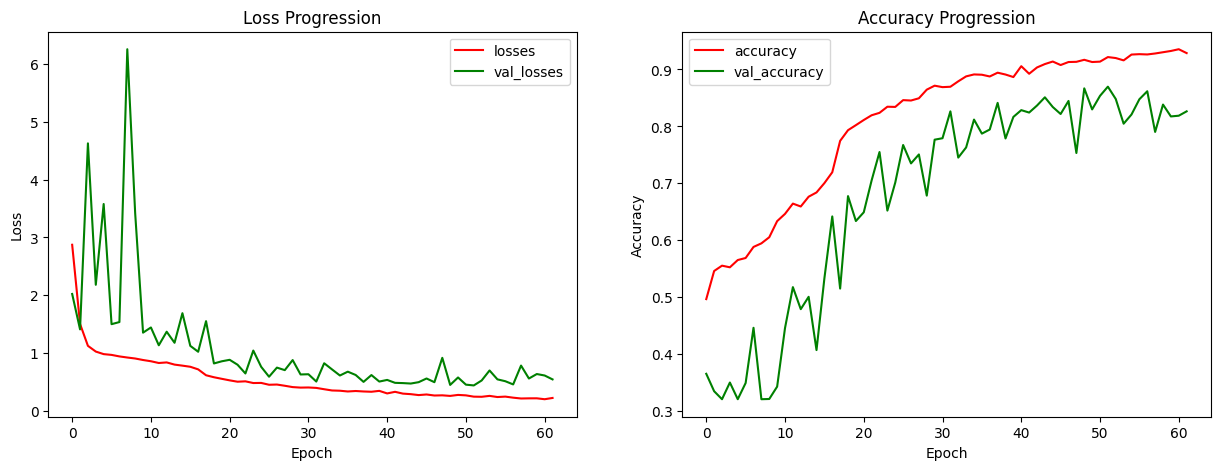

In [ ]:
#lets plot the accuracy and the loss graph
import matplotlib.pyplot as plt

# Plot the training and validation accuracy and losses
num_epochs = len(history.history['loss'])
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(range(num_epochs), history.history['loss'], color='purple', label='losses')
axes[0].plot(range(num_epochs), history.history['val_loss'], color='orange', label='val_losses')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss Progression')
axes[0].legend()

axes[1].plot(range(num_epochs), history.history['accuracy'], color='purple', label='accuracy')
axes[1].plot(range(num_epochs), history.history['val_accuracy'], color='orange', label='val_accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy Progression')
axes[1].legend()

plt.show()

In [ ]:
# The result of model.predict has an extra dimension, so we flatten to get a
# vector of predictions.
test_pred_train = np.argmax(model.predict(x_shuffled_train), axis=-1)
print(test_pred_train)

184/184 [==============================] - 53s 283ms/step
[1 0 0 ... 2 2 1]


In [ ]:
# The result of model.predict has an extra dimension, so we flatten to get a
# vector of predictions.
test_pred = np.argmax(model.predict(x_shuffled_val), axis=-1)
print(test_pred)

74/74 [==============================] - 20s 275ms/step
[2 2 2 ... 2 1 1]


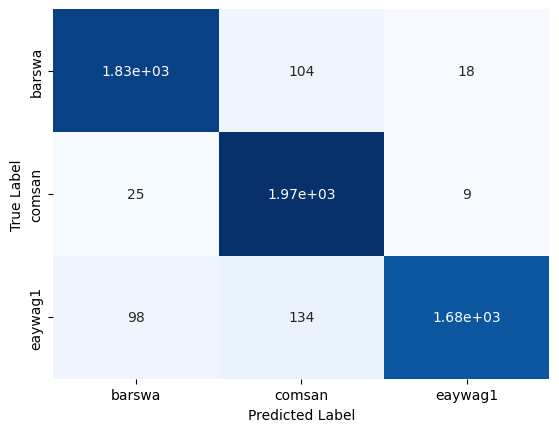

              precision    recall  f1-score   support

           0      0.937     0.938     0.937      1956
           1      0.892     0.983     0.935      2001
           2      0.984     0.879     0.928      1913

    accuracy                          0.934      5870
   macro avg      0.938     0.933     0.934      5870
weighted avg      0.937     0.934     0.934      5870



In [ ]:
#Training accuracy plots
#plot the confusion matrix
class_label = ['barswa',  'comsan',  'eaywag1']

# Create a confusion matrix as a 2D array.
from sklearn import metrics

y_train_1d = np.argmax(y_shuffled_train, axis=1)
confusion_matrix = tf.math.confusion_matrix(y_train_1d, test_pred_train)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=class_label, yticklabels=class_label, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

#Print the precision, recall and F1-score using metrics from sklearn
print(metrics.classification_report(y_train_1d, test_pred_train, digits=3, zero_division='warn'))

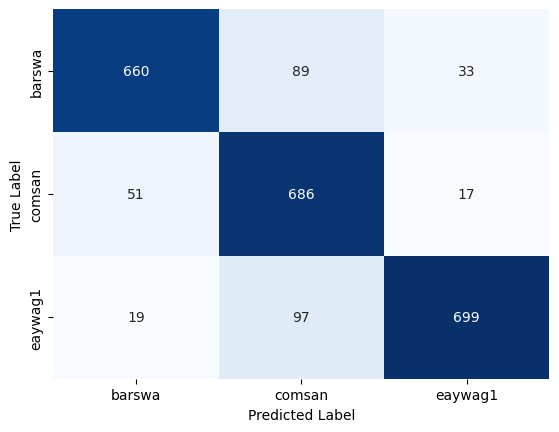

              precision    recall  f1-score   support

           0      0.904     0.844     0.873       782
           1      0.787     0.910     0.844       754
           2      0.933     0.858     0.894       815

    accuracy                          0.870      2351
   macro avg      0.875     0.870     0.870      2351
weighted avg      0.877     0.870     0.871      2351



In [ ]:
#plot the confusion matrix
class_label = ['barswa',  'comsan',  'eaywag1']

# Create a confusion matrix as a 2D array.
from sklearn import metrics


y_val_1d = np.argmax(y_shuffled_val, axis=1)
confusion_matrix = tf.math.confusion_matrix(y_val_1d, test_pred)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=class_label, yticklabels=class_label, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

#Print the precision, recall and F1-score using metrics from sklearn
print(metrics.classification_report(y_val_1d, test_pred, digits=3, zero_division='warn'))

In [ ]:
model.save('/content/drive/MyDrive/UCB-MIDS/SEM-2/MACHINE-LEARNING-207/207-Project/notebooks/HS/3e.lstm_8secmfcc_chroma.model.h5')